In [182]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [183]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [184]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.autograd import Variable

In [185]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [186]:
eval_size = 0.2
num_workers = 0
batch_size = 20

In [187]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.CIFAR10(root= "data", download = True, train = True, transform = transform)
test_data = datasets.CIFAR10(root= "data", download = True, train = False, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [188]:
num_train = len(train_data)
print("Total number of images available in CIFAR10 datasets: {}".format(num_train))

Total number of images available in CIFAR10 datasets: 50000


In [189]:
indices = list(range(num_train))
indices[:5]

[0, 1, 2, 3, 4]

In [190]:
np.random.shuffle(indices)
indices[:5]

[27923, 23708, 20847, 9708, 31137]

In [191]:
split = int(np.floor(num_train * eval_size))
train_idx, eval_idx = indices[:split], indices[split:]
train_idx[:5]
eval_idx[:5]

[27923, 23708, 20847, 9708, 31137]

[15755, 49949, 14985, 22057, 42728]

In [192]:
from torch.utils.data.sampler import SubsetRandomSampler

In [193]:
train_sampler = SubsetRandomSampler(train_idx)
eval_sampler = SubsetRandomSampler(eval_idx)

In [194]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
eval_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = eval_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                          shuffle = False, num_workers = num_workers)

In [195]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [196]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [197]:
type(images)
len(images)

torch.Tensor

20

In [198]:
classes[labels[0].item()]
images[0]

'cat'

tensor([[[-0.6392, -0.6314, -0.6392,  ..., -0.6549, -0.6784, -0.7020],
         [-0.6627, -0.6157, -0.6078,  ..., -0.6471, -0.6863, -0.7098],
         [-0.7490, -0.7098, -0.6235,  ..., -0.6706, -0.6941, -0.7176],
         ...,
         [ 0.9451,  0.9373,  0.9373,  ..., -0.4667, -0.0980,  0.0353],
         [ 0.9451,  0.9294,  0.9373,  ..., -0.3569,  0.0275,  0.1529],
         [ 0.9451,  0.9294,  0.9373,  ..., -0.3804, -0.1294, -0.0431]],

        [[-0.6314, -0.6392, -0.6549,  ..., -0.6627, -0.6863, -0.7098],
         [-0.6941, -0.6471, -0.6549,  ..., -0.6549, -0.6863, -0.7098],
         [-0.7647, -0.7490, -0.6863,  ..., -0.6627, -0.6941, -0.7176],
         ...,
         [ 0.9451,  0.9373,  0.9373,  ..., -0.4745, -0.0980,  0.0275],
         [ 0.9451,  0.9294,  0.9373,  ..., -0.3490,  0.0196,  0.1059],
         [ 0.9451,  0.9294,  0.9373,  ..., -0.3725, -0.1529, -0.1216]],

        [[-0.6392, -0.6314, -0.6314,  ..., -0.6941, -0.7255, -0.7490],
         [-0.6941, -0.6471, -0.6706,  ..., -0

In [199]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [200]:
InteractiveShell.ast_node_interactivity = 'none'

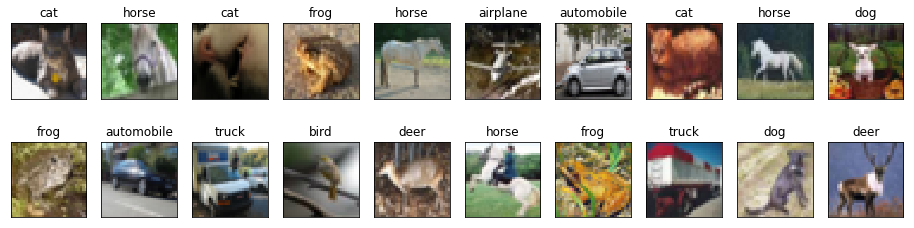

In [201]:
plt.figure(figsize = (16, 4))
for idx in range(len(images)):
    ax = plt.subplot(2, 10, idx+1, xticks = [], yticks = [])
    imshow(images[idx])
    ax.set_title(classes[labels[idx].item()])

In [202]:
class Cifar10CNN(nn.Module):
    
    def __init__(self):
        super(Cifar10CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3,
                              stride = 1, padding = 1, bias = True)
        
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5,
                              stride = 1, padding = 2, bias = True)

        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5,
                              stride = 1, padding = 2, bias = True)
        
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.hidden1 = nn.Linear(in_features = 64 * 4 * 4, out_features = 512, bias = True)

        self.hidden2 = nn.Linear(in_features = 512, out_features = 128, bias = True)

        self.output = nn.Linear(in_features = 128, out_features = 10, bias = True)
        
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(p = 0.20)

    def forward(self, x):
        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(x)
        x = self.relu(self.hidden1(x))
        
        x = self.dropout(x)
        x = self.relu(self.hidden2(x))
        
        x = self.dropout(x)
        x = self.output(x)
        
        return x        

In [203]:
InteractiveShell.ast_node_interactivity = 'all'

In [204]:
model = Cifar10CNN()
model.to(device)

Cifar10CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
)

In [205]:
criterion = nn.CrossEntropyLoss()
criterion

optimizer = optim.SGD(model.parameters(), lr = 0.01)
optimizer

CrossEntropyLoss()

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [206]:
InteractiveShell.ast_node_interactivity = 'none'

In [207]:
epochs = 4
training_loss = 0.0

In [208]:
for epoch in range(epochs):
    
    training_loss = 0.0
    for images, labels in train_loader:
        
        images, labels = images.to(device), labels.to(device)
        model.train()
        optimizer.zero_grad()
        
        output_predicted = model(images)
        loss = criterion(output_predicted, labels)
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()*labels.size(0)

    print('Epoch {} : Training Loss: {}'.format(epoch, training_loss/len(train_loader)))

Epoch 0 : Training Loss: 46.04707688331604
Epoch 1 : Training Loss: 45.99127552986145
Epoch 2 : Training Loss: 45.70218904495239
Epoch 3 : Training Loss: 42.69706297397614
